In [1]:
# Import Modules & Libraries

import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('stopwords') # can comment out if not needed on your computer

#Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

# import  from the fastai.text lib
!pip install fastai
from fastai.text import *

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dallis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# DATA CLEANING

In [2]:
#Import the Data

#Import Tweet Data
tweets=pd.read_csv('Tweets.csv')
tweets=tweets.drop(['tweet_id','name','tweet_created','tweet_location','user_timezone','airline_sentiment_gold','negativereason_gold','tweet_coord'],axis=1)

In [3]:
#Extracting usertags and hashtags

# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# function to collect airlines @
def usertag_extract(x):
    usertags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"@(\w+)", i)
        usertags.append(ht)
    return usertags

#extracting hashtags and usertags from tweets tweets
tweets["hashtags"] = hashtag_extract(tweets['text'])
tweets["usertags"] = usertag_extract(tweets['text'])

tweets["processed"] = tweets["text"].str.replace(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",'')
tweets["processed"] = tweets["processed"].str.replace(r'(?:@[\w_]+)', '')

In [4]:
#Remove contractions

# List of words used in the contractions dictionnary
contractions_dict = {"ain't": "am not","aren't": "are not am not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he had","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","i'd": "i had","i'd've": "I would have","i'll": "i will","i'll've": "i will have","i'm": "i am","I've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": " it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she had","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that had","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": " what will have","what're": "what are","what's": "what is","what've": "what have","when's": " when is","when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": " who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have","you'll": " you will","you'll've": "you will have","you're": "you are","you've": "you have" }

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

tweets["processed"] = tweets.processed.apply(expand_contractions)

In [5]:
#All html tags and attributes (i.e., /<[^>]+>/) are removed
tweets["processed"] = tweets["processed"].str.replace(r'/<[^<]+?>/', "")

#Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
#tweets.processed=tweets.processed.apply(unescape,unicode_snob=True)

#All URLs are removed
tweets["processed"] = tweets["processed"].str.replace(r"http\S+", "")
tweets["processed"] = tweets["processed"].str.replace(r"www\S+", "")

#All lowercase
tweets["processed"]= tweets.processed.apply(lambda x: x.lower()) 

#Other data cleaning
tweets['processed'].dropna(inplace=True)

#Only keep letters
tweets["processed"] = tweets["processed"].str.replace('[^a-zA-Z \n\.]', '')

#Remove punctuation
tweets["processed"] = tweets["processed"].str.replace('[^\w\s]','') 

#Remove two letter words
tweets["processed"] = tweets["processed"].str.replace(r'\W*\b\w{1,2}\b', '')

#Remove the word twitter
tweets["processed"] = tweets["processed"].str.replace(r"twitter", '')

#Remove words if a character appears more than 3 times
tweets["processed"] = tweets["processed"].str.replace("\\S*(\\S)\\1\\1\\S*\\s?", "")

In [6]:
#Remove stop words

stop_words=stop

pat = r'\b(?:{})\b'.format('|'.join(stop_words))
tweets['processed'] = tweets['processed'].str.replace(pat, '')
tweets['processed'] = tweets['processed'].str.replace(r'\s+', ' ')

# EXPLORATORY DATA ANALYSIS

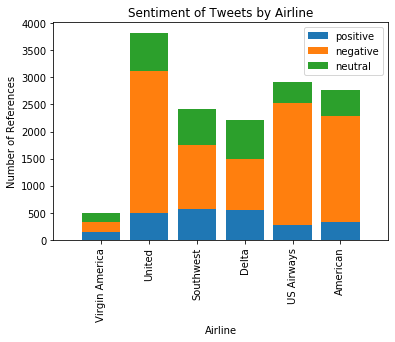

In [7]:
#tweets tweet visualization using bar graphs

pos_tweets = tweets["airline"][tweets["airline_sentiment"] == "positive"]
neg_tweets = tweets["airline"][tweets["airline_sentiment"] == "negative"]
neutral_tweets = tweets["airline"][tweets["airline_sentiment"] == "neutral"]

plt.hist([pos_tweets, neg_tweets,neutral_tweets], stacked=True,label=["positive", "negative","neutral"],bins = np.arange(8) - 0.5,rwidth=0.8)
plt.legend()
plt.title("Sentiment of Tweets by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of References")
plt.xticks(range(6),rotation=90)
plt.xlim([-1, 6])
plt.show()

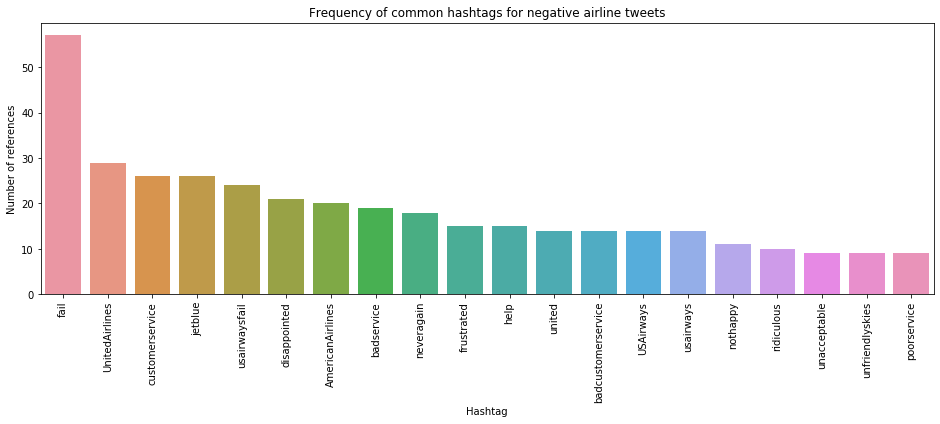

In [8]:
#Frequency of common hashtags for negative airline tweets

HT_tweets_neg = hashtag_extract(tweets['text'][tweets['airline_sentiment'] == 'negative'])

# unnesting list
HT_tweets_neg = sum(HT_tweets_neg,[])

a = nltk.FreqDist(HT_tweets_neg)
d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 

plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of references',xlabel='Hashtag')
plt.title("Frequency of common hashtags for negative airline tweets")
plt.xticks(rotation=90)
plt.show()

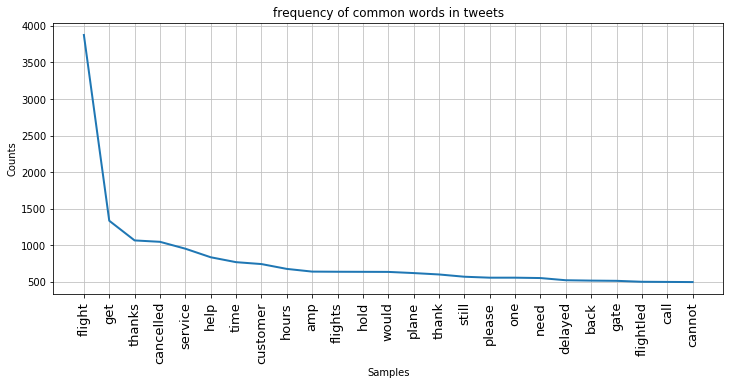

In [9]:
# Most common words in airline twitter dataset
all_words = []
for line in list(tweets['processed']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
        
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title("frequency of common words in tweets")
plt.xlabel('categories')
plt.ylabel('values')

fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# MODEL PREPARATION

In [10]:
path = Path('/Users/dallis/OneDrive - University of Toronto/COURSES')

tweets_processed=tweets[['processed','airline_sentiment']]

tweets_processed.loc[tweets_processed['airline_sentiment'] == "positive", "class"] = "1"
tweets_processed.loc[tweets_processed['airline_sentiment'] == "neutral", "class"] = "0"
tweets_processed.loc[tweets_processed['airline_sentiment'] == "negative", "class"] = "-1"

tweets_processed.head()

/Users/dallis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dallis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/dallis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

,processed,airline_sentiment,class
0,said,neutral,0
1,plus added commercials experience tacky,positive,1
2,today must mean need take another trip,neutral,0
3,really aggressive blast obnoxious entertainme...,negative,-1
4,really big bad thing,negative,-1


In [11]:
# Splitting data into training and validation set
tweets_train, tweets_test = train_test_split(tweets_processed,test_size=0.1,random_state=42)

In [12]:
#Create Data Bunches
data_lm = TextLMDataBunch.from_df(path,tweets_train,tweets_test, bs=32)
data_clas=TextClasDataBunch.from_df(path,tweets_train,tweets_test,label_cols=1, bs=32)

# CLASSIFICATION MODEL

#The idea here is to start with a low learning rate, record the loss, and repeat with increasingly high learning rates. If we plot the loss against the learning rate the learning rate should start to increase rapidly. The ULMFiT approach involves freezing the LSTM layers and then training the embedding layer. Once the model is unfreezed, the LSTM layers of the pretrained language model can be trained. The process consists of finding the best learning rate, training the top layers, unfreezing all layers and repeating.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


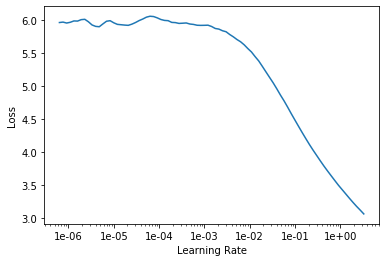

In [13]:
#Create the classification model and use fast ai learning rate finding
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.model
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(cyc_len=1,max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.327856,2.263967,0.321875,00:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


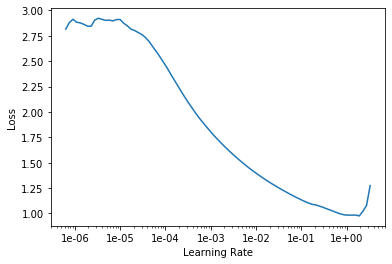

In [15]:
# unfreeze the LSTM layers of the model
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.484117,0.461270,0.816071,00:48
1,0.937569,0.475881,0.816295,00:59
2,0.748592,0.463693,0.816295,00:53
3,0.684624,0.482028,0.816295,00:51
4,0.620549,0.458090,0.816295,00:49
5,0.578657,0.461431,0.816295,00:50
6,0.550494,0.461371,0.816295,00:53
7,0.530228,0.458874,0.816295,00:49
8,0.514684,0.459800,0.816295,00:47
9,0.503803,0.460022,0.816295,00:52


In [17]:
#save the encoder
learn.save_encoder('encoder')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


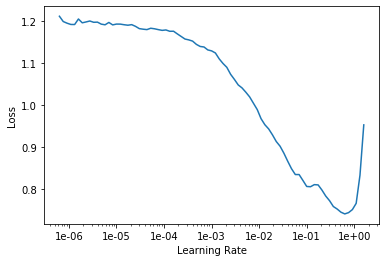

In [19]:
#apply the encoder
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('encoder')
learn.model
learn.lr_find()
learn.recorder.plot()

In [20]:
#gradual unfreezing
learn.fit_one_cycle(1,1e-2)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))


epoch,train_loss,valid_loss,accuracy,time
0,0.216015,0.040541,1.000000,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.066775,0.006075,1.000000,01:13


In [21]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/2.,5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.021986,0.000248,1.000000,01:56


In [22]:
learn.unfreeze()
learn.fit_one_cycle(1,slice(2e-3/100,2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.017038,0.000071,1.000000,02:31


# PREDICT

In [23]:
#This shows the probability value for each of the classes
learn.predict("I really loved the flight")

(Category tensor(2), tensor(2), tensor([2.4066e-02, 2.5335e-04, 9.7568e-01]))